# Prompts

In [1]:
import os
import pickle
import time
from diffusers import StableDiffusionPipeline
import time
import os
import pickle

prompts = [
    "A vibrant marketplace with stalls selling exotic goods.",
    "A mystical underwater cave filled with bioluminescent creatures.",
    "A colorful parrot perched on a tree branch.",
    "A beautiful woman with her cat in a garden full of flowers."
]

C:\Users\vegag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility functions

In [2]:
def predict_image(pipe, prompt, times):
    start = time.time()
    image = pipe(prompt).images[0]
    end = time.time()

    times.append(end - start)

    return image

# Experiments

## DPM vs DDIM

### DPM pipeline

In [3]:
from diffusers import DPMSolverMultistepScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
dpm_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
dpm_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    dpm_pipe.scheduler.config
)
dpm_pipe = dpm_pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


### DDIM pipeline

In [4]:
from diffusers import DDIMScheduler
import torch


model_id = "stabilityai/stable-diffusion-2-1"

# Use the DDIMScheduler(DPM-Solver++) scheduler here instead
dim_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
dim_pipe.scheduler = DDIMScheduler.from_config(
    dim_pipe.scheduler.config, rescale_betas_zero_snr=True, timestep_spacing="trailing"
)
dim_pipe = dim_pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


### Image generation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

time_dpm = []
time_dim = []

for prompt in prompts:
    image_dpm = predict_image(dpm_pipe, prompt, time_dpm)
    image_dim = predict_image(dim_pipe, prompt, time_dim)

    # Create a figure and set of subplots
    fig, axes = plt.subplots(1, 2)

    # Plot first image
    axes[0].imshow(image_dpm)
    axes[0].set_title('Image DPM-Solver')
    axes[0].axis('off')

    # Plot second image
    axes[1].imshow(image_dim)
    axes[1].set_title('Image DIM')
    axes[1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    # plt.savefig(f"{'task_b_dpmvsdim_v1'}/diffusion_{prompt}.png")
    plt.cla()

## Positive and negative prompting

In [ ]:
from diffusers import DPMSolverMultistepScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
dpm_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
dpm_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    dpm_pipe.scheduler.config
)
dpm_pipe = dpm_pipe.to("cuda")

In [ ]:
prompts_negative = [
    "Pink flowers",
    "Pretty and alive flowers",
    "Persian cat.",
    "Stray cat",
    "Brunette woman",
    "Russian-like woman",
    "Simple clothes", # Per provar a veure com va amb un cosa que no es al actual prompt
    "Young woman",
    "Not dressed like a clown", # Psicologia inversa
    "Abundant garden"
]

actual_prompt = "A beautiful woman with her cat in a garden full of flowers."

In [ ]:
def predict_image_w_negative(pipe, prompt, times, negative_prompt):
    start = time.time()
    
    image = pipe(prompt=prompt, negative_prompt=negative_prompt).images[0]
    end = time.time()

    times.append(end - start)

    return image

In [ ]:
for negative_prompt in prompts_negative:
    
    images_no_negative = []
    for i in range(5):
        images_no_negative.append(predict_image(dpm_pipe, actual_prompt, []))

    images_negative = []
    for i in range(5):
        images_negative.append(predict_image_w_negative(dpm_pipe, actual_prompt, [], negative_prompt))

    # Create a figure and set of subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Plot images from the first list (image_dpm_list)
    for i, image_dpm in enumerate(images_no_negative):
        ax = axes[0, i]
        ax.imshow(image_dpm)
        ax.axis('off')

    # Plot images from the second list (image_dim_list)
    for i, image_dim in enumerate(images_negative):
        ax = axes[1, i]
        ax.imshow(image_dim)
        ax.axis('off')

    axes[1][2].set_title(negative_prompt)

    # Show the plot
    plt.savefig(f"{'task_b_negprompt'}/diffusion_{negative_prompt}.png")
    plt.cla()

## Strength of CFG

In [62]:
def predict_image_cfg(pipe, prompt, times, cfg):
    start = time.time()
    image = pipe(prompt, guidance_scale=cfg).images[0]
    end = time.time()

    times.append(end - start)

    return image

In [78]:
different_cfgs = [0, 1, 3, 10, 20, 30, 40, 50, 60, 70, 100]
actual_prompt = "A beautiful woman with her cat in a garden full of flowers."
cfg_time = []

In [64]:
images_total = []
for different_cfg in different_cfgs:
    images_cfg = []

    for i in range(5):
        start = time.time()
        image = predict_image_cfg(dpm_pipe, actual_prompt, cfg_time, different_cfg)
        end = time.time()

        cfg_time.append(end - start)
        images_cfg.append(image)

    images_total.append(images_cfg)

100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


In [79]:
for different_cfg in [50, 60, 70, 100]:
    images_cfg = []

    for i in range(5):
        start = time.time()
        image = predict_image_cfg(dpm_pipe, actual_prompt, cfg_time, different_cfg)
        end = time.time()

        cfg_time.append(end - start)
        images_cfg.append(image)

    images_total.append(images_cfg)

100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


In [80]:
len(images_total) == len(different_cfgs)

True

In [ ]:
# Adjust figsize as needed
for i, images in enumerate(images_total):
    fig, axes = plt.subplots(1, 5, figsize=(18, 6))
    fig.suptitle(f'CFG: {different_cfgs[i]}', fontsize=16)
    for j, image in enumerate(images):
        # Plot first image
        axes[j].imshow(image)
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.savefig(f"{'task_b_cfg'}/CFG_{different_cfgs[i]}.png")
    plt.cla()

# Numero of denoising steps

In [82]:
def predict_image_steps(pipe, prompt, times, steps):
    start = time.time()
    image = pipe(prompt, num_inference_steps=steps).images[0]
    end = time.time()

    times.append(end - start)

    return image

In [84]:
steps_denoise = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]
actual_prompt = "A beautiful woman with her cat in a garden full of flowers."
step_time = []

In [85]:
for denoised in steps_denoise:
    image = predict_image_steps(dpm_pipe, actual_prompt, step_time, denoised)

    image.save(f"{'task_b_steps'}/steps_{denoised}.png")

100%|██████████| 200/200 [00:24<00:00,  8.21it/s]


Text(0, 0.5, 'Time (s)')

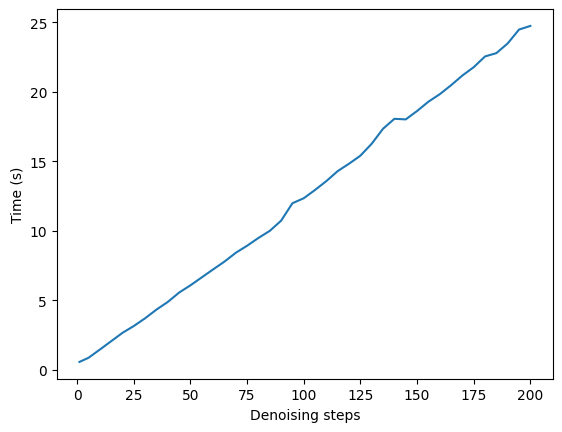

In [94]:
plt.plot(steps_denoise, step_time)
plt.xlabel('Denoising steps')
plt.ylabel('Time (s)')